In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensordash.tensordash import Tensordash
import tensorflow as tf
import time

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

# Data preprocessing

In [3]:
table=pd.read_csv("fer2013.csv").values
x=list()
for i in range(table.shape[0]):
    table[i][1]=np.uint8(np.asarray(table[i][1].split(' ')).reshape((48,48,1)))
    im=table[i][1]
    im=cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
    x.append(im)
    print("Current row : %d"%i,end="\r")
print("\nDone!")
table=table[:,:-1]
x=np.asarray(x)
y=np.uint8(table[:,0])
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y = onehot_encoder.fit_transform(y.reshape(-1,1))
xtrain=x[:28709,:,:,:]
xtestpub=x[28709:32298,:,:,:]
xtestpri=x[32298:,:,:,:]
ytrain=y[:28709,:]
ytestpub=y[28709:32298,:]
ytestpri=y[32298:,:]
np.save("xtrain.npy",xtrain)
np.save("ytrain.npy",ytrain)
np.save("xtestpri.npy",xtestpri)
np.save("ytestpri.npy",ytestpri)
np.save("xtestpub.npy",xtestpub)
np.save("ytestpub.npy",ytestpub)

Current row : 35886
Done!


In [15]:
xtrain=np.load("xtrain.npy")
ytrain=np.load("ytrain.npy")
xtestpri=np.load("xtestpri.npy")
ytestpri=np.load("ytestpri.npy")
xtestpub=np.load("xtestpub.npy")
ytestpub=np.load("ytestpub.npy")

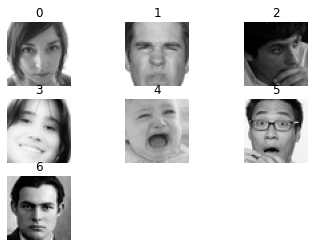

In [4]:
fig=plt.figure()
for i in range(7):
    ax=fig.add_subplot(3,3,i+1)
    ax.set_title(str(i))
    ax.axis('off')
    temp=random.randint(0,xtrain[ytrain[:,i]==1].shape[0]-1)
    ax.imshow(np.uint8(xtrain[ytrain[:,i]==1][temp]),cmap='gray')
plt.show()

In [5]:
x=preprocess_input(x)

# Model declaration

In [6]:
resnet=ResNet50(weights='imagenet', include_top=False, input_shape=(x.shape[1],x.shape[2],3))
resnet.summary()

n[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 6, 6, 512)    0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 3, 3, 256)    131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 3, 3, 256)    1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 3, 3, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 3, 3, 256)    590080      conv4_block1_1_relu[0][0] 

In [7]:
# model.add(Input(shape=(48,48,1)))
# model.add(Conv2D(filters=3,kernel_size=3,padding='same'))
for layer in resnet.layers:
    layer.trainable = False
resnet.trainable=False
mx=GlobalAveragePooling2D()(resnet.output)
mx=Dense(2048,activation='relu')(mx)
mx=Dense(y.shape[1],activation='softmax')(mx)
model=Model(resnet.input,mx)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 3, 3, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 3, 3, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 3, 3, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 3, 3, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 3, 3, 1024)   525312      conv3_block4_out[0][0]       

# Model Performance Trackers

In [8]:
tensorboard=TensorBoard(log_dir="log/%f"%(time.time()))
tensorboard.set_model(model)

In [9]:
histories=Tensordash(email='sagnik106@gmail.com', password='ZeusTrident3', ModelName='Facial Emotion Recognition')

# Training

In [10]:
with tf.device('/gpu:0'):
    history=model.fit(xtrain,ytrain,epochs=25,batch_size=32,validation_data=(xtestpub,ytestpub),shuffle=True,verbose=1,callbacks=[tensorboard, histories])

Epoch 1/25
898/898 [==============================] - 18s 20ms/step - loss: 1.6846 - accuracy: 0.3859 - val_loss: 1.5259 - val_accuracy: 0.4152
Epoch 2/25
898/898 [==============================] - 16s 18ms/step - loss: 1.4658 - accuracy: 0.4420 - val_loss: 1.4920 - val_accuracy: 0.4330
Epoch 3/25
898/898 [==============================] - 17s 19ms/step - loss: 1.3918 - accuracy: 0.4653 - val_loss: 1.4778 - val_accuracy: 0.4319
Epoch 4/25
898/898 [==============================] - 17s 19ms/step - loss: 1.3161 - accuracy: 0.4985 - val_loss: 1.5362 - val_accuracy: 0.4257
Epoch 5/25
898/898 [==============================] - 17s 19ms/step - loss: 1.2450 - accuracy: 0.5281 - val_loss: 1.5205 - val_accuracy: 0.4444
Epoch 6/25
898/898 [==============================] - 18s 20ms/step - loss: 1.1626 - accuracy: 0.5639 - val_loss: 1.5625 - val_accuracy: 0.4464
Epoch 7/25
898/898 [==============================] - 18s 20ms/step - loss: 1.0829 - accuracy: 0.5963 - val_loss: 1.6273 - val_accuracy:

# Model Performance

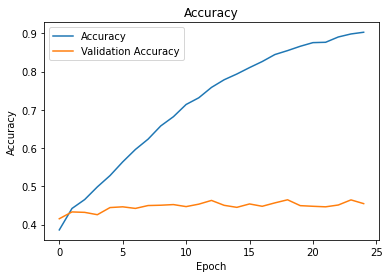

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.savefig("resources/Accuracy.png")
plt.show()

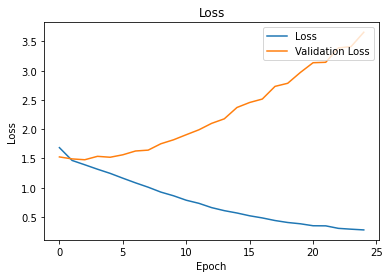

In [12]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig("resources/Loss.png")
plt.show()

# Saving the model

In [13]:
model.save("detect.h5")

# Testing

In [14]:
p=model.evaluate(xtestpri,ytestpri)

113/113 [==============================] - 2s 14ms/step - loss: 3.6281 - accuracy: 0.4550
